<a href="https://colab.research.google.com/github/lualua0909/DeepLearning-LDS8/blob/main/Week_3/Chapter_6_Demo_TimeSeries_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Air Pollution Forecasting
We can use this data and frame a forecasting problem where, given the weather
conditions and pollution for prior hours, we forecast the pollution at the next
hour.

In [2]:
from datetime import datetime
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
dataset = pd.read_csv('https://github.com/lualua0909/DeepLearning-LDS8/blob/main/Data/pollution_new_1.csv?raw=true', index_col= 0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [5]:
dataset.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


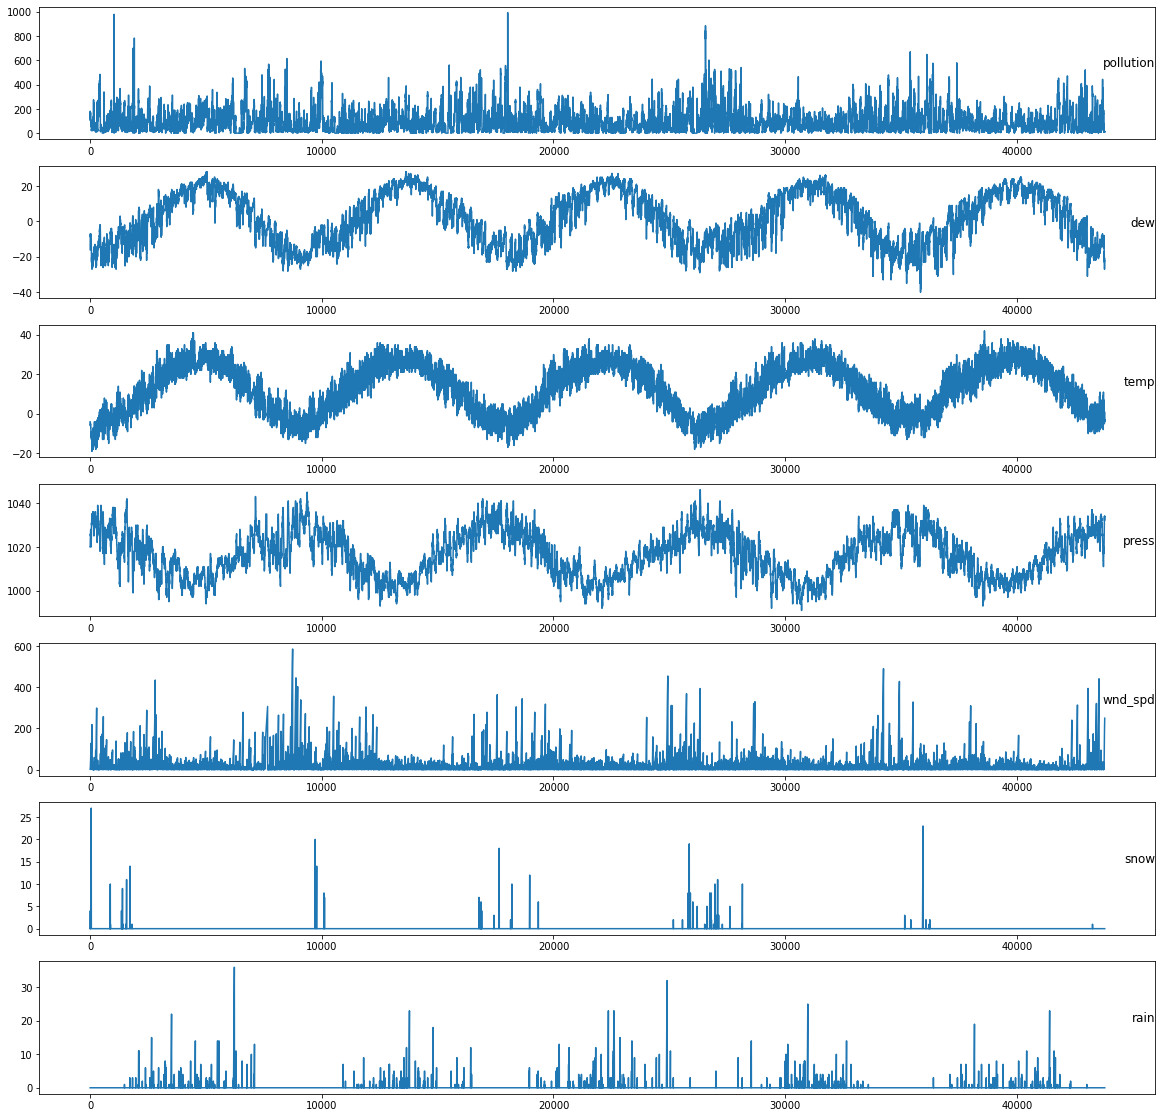

In [7]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7] # vì cột 4 là cột kiểu chuỗi
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group])
  plt.title(dataset.columns[group], y=0.5, loc='right')
  i += 1
plt.show()

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
  return agg

In [10]:
# # load dataset
values = dataset.values
# integer encode direction
# chuyển cột kiểu chuỗi thành kiểu số
encoder = LabelEncoder()
encoder.fit(values[:,4])
values[:,4] = encoder.transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
print("Frame as Series:")
print(scaled[:5])

Frame as Series:
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]
 [0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]
 [0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
  0.03703704 0.        ]
 [0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
  0.07407407 0.        ]]


In [11]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print("Frame as supervised learning:")
print(reframed.head())
# Vì chỉ predict thông tin var1(t), còn từ var2(t) trở đi không dự đoán nên drop
# giữ lại các cột từ 0-8 (8 cột đầu là inputs, cột cuối là output)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("Frame will use:")
print(reframed.head())

Frame as supervised learning:
   var1(t-1)  var2(t-1)  var3(t-1)  ...   var6(t)   var7(t)  var8(t)
1   0.129779   0.352941   0.245902  ...  0.003811  0.000000      0.0
2   0.148893   0.367647   0.245902  ...  0.005332  0.000000      0.0
3   0.159960   0.426471   0.229508  ...  0.008391  0.037037      0.0
4   0.182093   0.485294   0.229508  ...  0.009912  0.074074      0.0
5   0.138833   0.485294   0.229508  ...  0.011433  0.111111      0.0

[5 rows x 16 columns]
Frame will use:
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


In [12]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 4 # vì dữ liệu theo giờ (lấy 4 năm đầu train)
train = values[:n_train_hours, :]
# còn lại thì là test
test = values[n_train_hours:, :]
# split into input and outputs (các cột đầu, cột cuối)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print("Before reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]

Before reshape:
(35040, 8) (35040,) (8759, 8) (8759,)


In [13]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("After reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

After reshape:
(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [14]:
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [15]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1 sample has 8 featur
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2)

Epoch 1/50
487/487 - 10s - loss: 0.0270 - val_loss: 0.0127 - 10s/epoch - 21ms/step
Epoch 2/50
487/487 - 2s - loss: 0.0138 - val_loss: 0.0132 - 2s/epoch - 5ms/step
Epoch 3/50
487/487 - 2s - loss: 0.0137 - val_loss: 0.0124 - 2s/epoch - 5ms/step
Epoch 4/50
487/487 - 2s - loss: 0.0137 - val_loss: 0.0124 - 2s/epoch - 4ms/step
Epoch 5/50
487/487 - 2s - loss: 0.0137 - val_loss: 0.0126 - 2s/epoch - 5ms/step
Epoch 6/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0132 - 2s/epoch - 5ms/step
Epoch 7/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0125 - 2s/epoch - 4ms/step
Epoch 8/50
487/487 - 3s - loss: 0.0137 - val_loss: 0.0124 - 3s/epoch - 5ms/step
Epoch 9/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0126 - 2s/epoch - 5ms/step
Epoch 10/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0131 - 2s/epoch - 5ms/step
Epoch 11/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0124 - 2s/epoch - 5ms/step
Epoch 12/50
487/487 - 2s - loss: 0.0137 - val_loss: 0.0125 - 2s/epoch - 5ms/step
Epoch 13/50
487/487 - 2s - loss: 0

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


* lstm (LSTM) = [(num_units + input_dim + 1) x num_units] x 4 = [(32 + 8 + 1) x 32] x 4 = 5248
* dense = ((current layer n x previous layer n) + bias) = 1 x 32 + 1 = 33

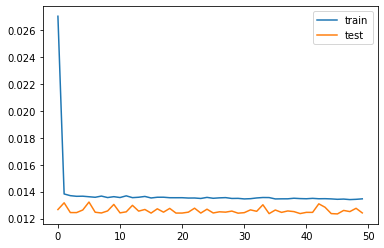

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
test_X.shape

(8759, 1, 8)

In [19]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [20]:
def invert_scaling(y, X, s):
  # invert scaling for forecast
  inv_y = np.concatenate((y, X[:, 1:]), axis=1)
  print(s, "shape:", inv_y.shape)
  inv_y = scaler.inverse_transform(inv_y)
  print(s, inv_y.shape)
  # trả lại hình dạng ban đầu
  inv_y = inv_y[:,0]
  return inv_y

In [21]:
# make a prediction
yhat = model.predict(test_X)
print("Test_x_shape:", test_X.shape)
test_X_now = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print("Test_x_now_shape:", test_X_now.shape)
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat, test_X_now[:, 1:]), axis=1)
# print("inv_y_hat_shape:", inv_yhat.shape)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# print("inv_yhat:", inv_yhat.shape)
# # trả lại hình dạng ban đầu
# inv_yhat = inv_yhat[:,0]
inv_yhat = invert_scaling(yhat, test_X_now, "inv_yhat")
# invert scaling for actual
# inv_y = np.concatenate((test_y, test_X_now[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = invert_scaling(test_y, test_X_now, "inv_y")

Test_x_shape: (8759, 1, 8)
Test_x_now_shape: (8759, 8)
inv_yhat shape: (8759, 8)
inv_yhat (8759, 8)
inv_y shape: (8759, 8)
inv_y (8759, 8)


In [22]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 24.192
Test MAE: 12.345


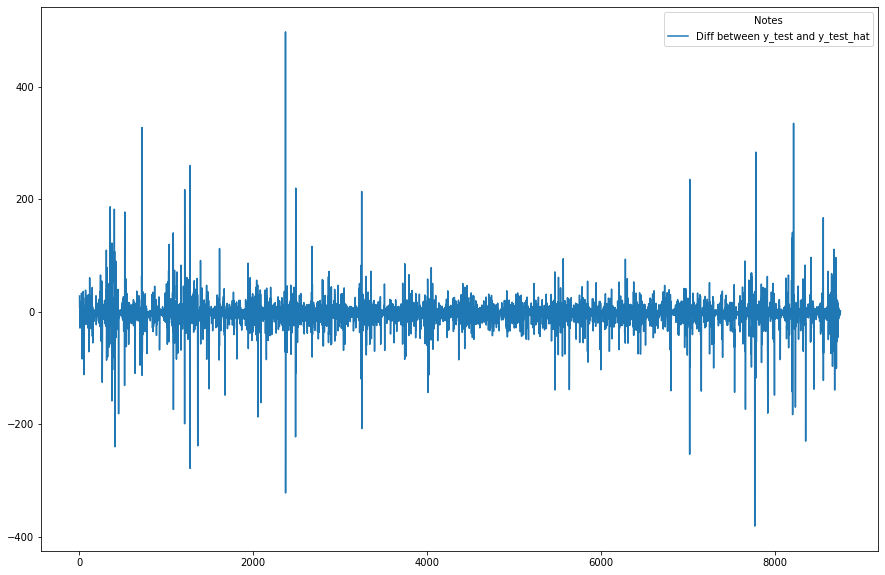

In [23]:
plt.figure(figsize=(15,10))
plt.plot(inv_y - inv_yhat, label='Diff between y_test and y_test_hat')
plt.legend(title="Notes")
plt.show()

In [24]:
# make a prediction of y
y_train_hat = model.predict(train_X)
train_X_now = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
# inv_y_train_hat = np.concatenate((y_train_hat, train_X_now[:, 1:]), axis=1)
# inv_y_train_hat = scaler.inverse_transform(inv_y_train_hat)
# inv_y_train_hat = inv_y_train_hat[:,0]
inv_y_train_hat = invert_scaling(y_train_hat, train_X_now, "inv_y_train_hat")

inv_y_train_hat shape: (35040, 8)
inv_y_train_hat (35040, 8)


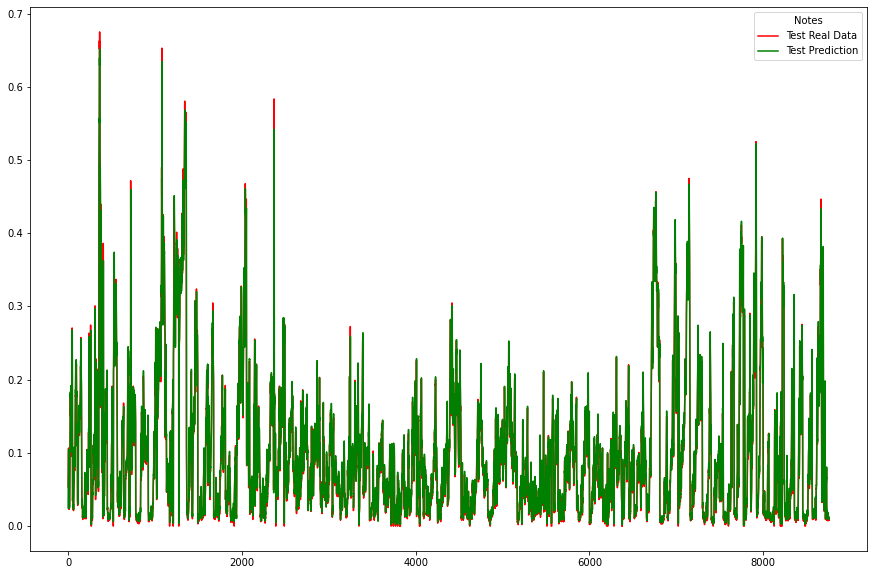

In [25]:
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.plot(test_y, label='Test Real Data', color='red')
plt.plot(yhat, label='Test Prediction', color='green')
plt.legend(title="Notes")
plt.show()

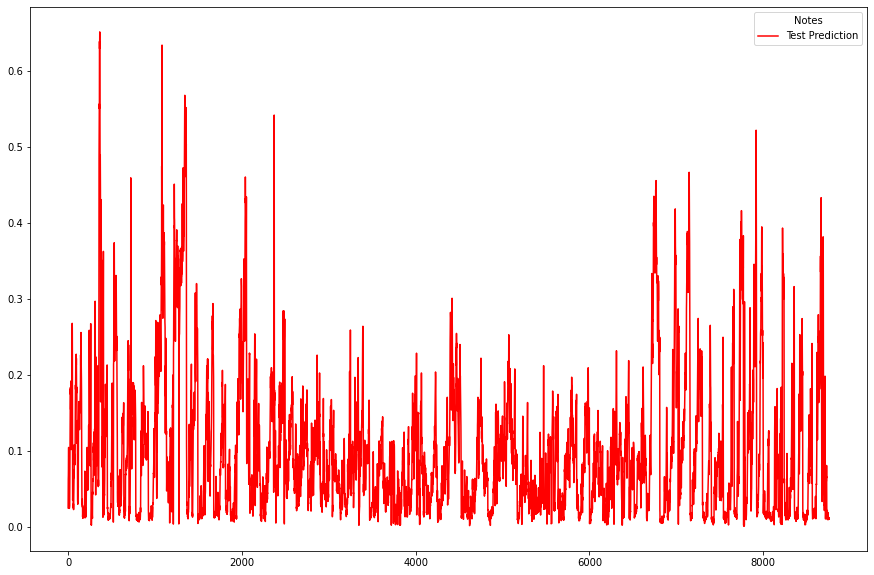

In [26]:
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.plot(yhat, label='Test Prediction', color='red')
plt.legend(title="Notes")
plt.show()

In [27]:
print('Val_loss train')
model.evaluate(train_X, train_y)

Val_loss train
1095/1095 [==============================] - 4s 3ms/step - loss: 0.0134


0.01344497874379158

In [28]:
print('Val_loss test')
model.evaluate(test_X, test_y)

Val_loss test
274/274 [==============================] - 1s 4ms/step - loss: 0.0124


0.01241955254226923

##Make new prediction

In [30]:
dataset_new = pd.read_csv('https://raw.githubusercontent.com/lualua0909/DeepLearning-LDS8/main/Data/pollution_new_predict.csv', index_col= 0)
dataset_new.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
12/31/2014 23:00,12,-21,-3,1034,NW,249.85,0,0
1/1/2015 0:00,0,0,0,0,NW,0.00,0,0


In [31]:
values_new = dataset_new.values
values_new

array([[12, -21, -3, 1034, 'NW', 249.85, 0, 0],
       [0, 0, 0, 0, 'NW', 0.0, 0, 0]], dtype=object)

In [32]:
values_new[:,4] = encoder.transform(values_new[:,4])
# ensure all data is float
values_new = values_new.astype('float32')
values_new.size

16

In [33]:
values_new

array([[ 1.2000e+01, -2.1000e+01, -3.0000e+00,  1.0340e+03,  1.0000e+00,
         2.4985e+02,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00]], dtype=float32)

In [34]:
scaled_new = scaler.transform(values_new)
scaled_new

array([[ 1.2072435e-02,  2.7941179e-01,  2.6229507e-01,  7.8181839e-01,
         3.3333334e-01,  4.2621556e-01,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  5.8823532e-01,  3.1147540e-01, -1.8018181e+01,
         3.3333334e-01, -7.6903362e-04,  0.0000000e+00,  0.0000000e+00]],
      dtype=float32)

In [35]:
# convert dataframe as supervised learning
reframed_new = series_to_supervised(scaled_new, 1, 1)
reframed_new.drop(reframed_new.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed_new.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.012072,0.279412,0.262295,0.781818,0.333333,0.426216,0.0,0.0,0.0


In [36]:
reframed_new.shape

(1, 9)

In [37]:
values_new = reframed_new.values
# split into input and outputs
new_pre = values_new[:, :-1]
# reshape input to be 3D [samples, timesteps, features]
new_pre = new_pre.reshape((new_pre.shape[0], 1, new_pre.shape[1]))
new_pre.shape

(1, 1, 8)

In [38]:
yhat_new_pre = model.predict(new_pre)
yhat_new_pre

array([[0.01371897]], dtype=float32)

In [41]:
# invert scaling for actual
yhat_new_pre = yhat_new_pre.reshape((len(yhat_new_pre), 1))
new_pre_now = new_pre.reshape((new_pre.shape[0], new_pre.shape[2]))
# yhat_new_pre = np.concatenate((yhat_new_pre, new_pre_now[:, 1:]), axis=1)
# yhat_new_pre = scaler.inverse_transform(yhat_new_pre)
# yhat_new_pre = yhat_new_pre[:,0]
yhat_new_pre = invert_scaling(yhat_new_pre, new_pre_now, "yhat_new_pre")
yhat_new_pre

yhat_new_pre shape: (1, 8)
yhat_new_pre (1, 8)


array([13.636653], dtype=float32)